In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

import ta
from ta import add_all_ta_features
from ta.utils import dropna

### 1. Read and visualize dataset

In [25]:
datasets = ['ali', 'copper', 'lead', 'nickel', 'zinc']
dataset_idx = 3

In [26]:
dataset_file = "./Data/{}.csv".format(datasets[dataset_idx])
df = pd.read_csv(dataset_file, index_col=0)
df['date'] = pd.to_datetime(df['date'])
df[df.isna().any(axis=1)]

,date,PX_LAST,PX_HIGH,PX_LOW,PX_OPEN,PX_VOLUME
3788,2018-12-25,10875,10875,10875,10875,NaN
3792,2019-01-01,10645,10645,10645,10645,NaN


In [27]:
# Clean NaN values
df = dropna(df)
df.set_index('date', drop=True, inplace=True)
df.head()

,PX_LAST,PX_HIGH,PX_LOW,PX_OPEN,PX_VOLUME
date,,,,,
2004-01-02,16600,16800,16600,16700,10.0
2004-01-05,17150,17150,16700,16950,43.0
2004-01-06,15700,17700,15250,17200,240.0
2004-01-07,15375,15650,15110,15600,229.0
2004-01-08,16300,16300,15350,15600,377.0


In [28]:
for col in df.columns:
    df[col] = df[col].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5438 entries, 2004-01-02 to 2025-07-18
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PX_LAST    5438 non-null   float64
 1   PX_HIGH    5438 non-null   float64
 2   PX_LOW     5438 non-null   float64
 3   PX_OPEN    5438 non-null   float64
 4   PX_VOLUME  5438 non-null   float64
dtypes: float64(5)
memory usage: 254.9 KB


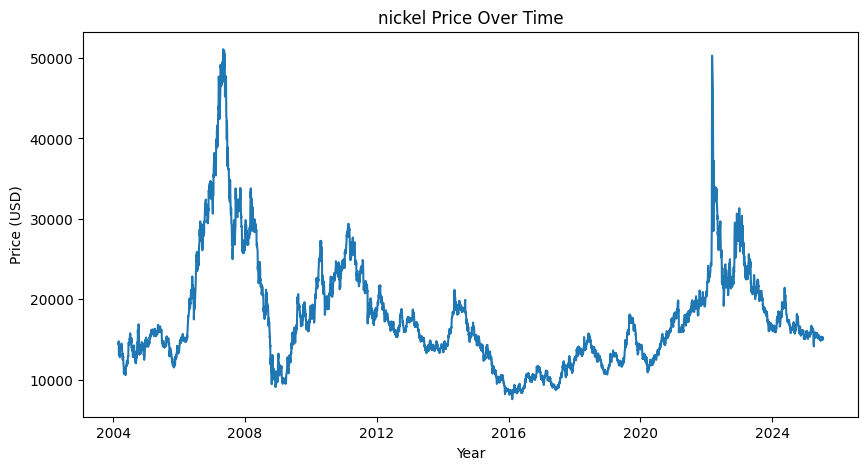

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(df.PX_LAST)
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.title("{} Price Over Time".format(datasets[dataset_idx]))
plt.show()

In [29]:
window = 20

df['SMA'] = ta.trend.sma_indicator(df.PX_LAST, window=window, fillna=False)
df['EMA'] = ta.trend.ema_indicator(df.PX_LAST, window=window, fillna=False)
df['WMA'] = ta.trend.ema_indicator(df.PX_LAST, window=window, fillna=False)
df['HLC3'] = (df.PX_HIGH + df.PX_LOW + df.PX_LAST) / 3
df['ATR'] = ta.volatility.average_true_range(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, fillna=False)
df['UL'] = ta.volatility.ulcer_index(df.PX_LAST, window=window, fillna=False)

df['BBU'] = ta.volatility.bollinger_hband(df.PX_LAST, window=window, window_dev=2, fillna=False)
# df['BBM'] = ta.volatility.bollinger_mavg(df.PX_LAST, window=window, fillna=False) # same with SMA
df['BBL'] = ta.volatility.bollinger_lband(df.PX_LAST, window=window, window_dev=2, fillna=False)

df['DCU'] = ta.volatility.donchian_channel_hband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, offset=0, fillna=False)
df['DCM'] = ta.volatility.donchian_channel_lband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, offset=0, fillna=False)
df['DCL'] = ta.volatility.donchian_channel_mband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, offset=0, fillna=False)

df['KCU'] = ta.volatility.keltner_channel_hband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, window_atr=10, fillna=False, original_version=False)
# df['KCM'] = ta.volatility.keltner_channel_mband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, window_atr=10, fillna=False, original_version=False) # same with EMA
df['KCL'] = ta.volatility.keltner_channel_lband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, window_atr=10, fillna=False, original_version=False)

df['ROC'] = ta.momentum.roc(df.PX_LAST, window=window, fillna=False)
df['KST'] = ta.trend.kst(df.PX_LAST, roc1=10, roc2=15, roc3=20, roc4=30, window1=10, window2=10, window3=10, window4=15, fillna=False)
df['KST_SIG'] = ta.trend.kst_sig(df.PX_LAST, roc1=10, roc2=15, roc3=20, roc4=30, window1=10, window2=10, window3=10, window4=15, nsig=9, fillna=False)

df['Ichimoku_conversion'] = ta.trend.ichimoku_conversion_line(df.PX_HIGH, df.PX_LOW, window1=9, window2=26, visual=False, fillna=False)
df['Ichimoku_base'] = ta.trend.ichimoku_base_line(df.PX_HIGH, df.PX_LOW, window1=9, window2=26, visual=False, fillna=False)
df['Ichimoku_a'] = ta.trend.ichimoku_a(df.PX_HIGH, df.PX_LOW, window1=9, window2=26, visual=False, fillna=False)
df['Ichimoku_b'] = ta.trend.ichimoku_b(df.PX_HIGH, df.PX_LOW, window2=26, window3=52, visual=False, fillna=False)

df['MACD'] = ta.trend.macd(df.PX_LAST, window_slow=26, window_fast=12, fillna=False)
df['MACD_SIG'] = ta.trend.macd_signal(df.PX_LAST, window_slow=26, window_fast=12, window_sign=9, fillna=False)

df['MI'] = ta.trend.mass_index(df.PX_HIGH, df.PX_LOW, window_fast=9, window_slow=25, fillna=False)
df['CCI'] = ta.trend.cci(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, constant=0.015, fillna=False)

# df['PSARU'] = ta.trend.psar_up(df.PX_HIGH, df.PX_LOW, df.PX_LAST, step=0.02, max_step=0.2, fillna=True)
# df['PSARD'] = ta.trend.psar_down(df.PX_HIGH, df.PX_LOW, df.PX_LAST, step=0.02, max_step=0.2, fillna=True)

df['AROONU'] = ta.trend.aroon_up(df.PX_HIGH, df.PX_LOW, window=window, fillna=False)
df['AROOND'] = ta.trend.aroon_down(df.PX_HIGH, df.PX_LOW, window=window, fillna=False)

df['AO'] = ta.momentum.awesome_oscillator(df.PX_HIGH, df.PX_LOW, window1=5, window2=34, fillna=False)
df['KAMA'] = ta.momentum.kama(df.PX_LAST, window=window, pow1=2, pow2=30, fillna=False)

df['PPO'] = ta.momentum.ppo(df.PX_LAST, window_slow=26, window_fast=12, window_sign=9, fillna=False)
df['PPO_SIG'] = ta.momentum.ppo_signal(df.PX_LAST, window_slow=26, window_fast=12, window_sign=9, fillna=False)

df['PVO'] = ta.momentum.pvo(df.PX_VOLUME, window_slow=26, window_fast=12, window_sign=9, fillna=False)
df['PVO_SIG'] = ta.momentum.pvo_signal(df.PX_VOLUME, window_slow=26, window_fast=12, window_sign=9, fillna=False)

df['RSI'] = ta.momentum.rsi(df.PX_LAST, window=window, fillna=False)
df['Stochastic'] = ta.momentum.stoch(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, smooth_window=3, fillna=False)
df['TSI'] = ta.momentum.tsi(df.PX_LAST, window_slow=25, window_fast=13, fillna=False)
df['ADX'] = ta.trend.adx(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, fillna=False)
df['FI'] = ta.volume.force_index(df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)

df['EMV'] = ta.volume.ease_of_movement(df.PX_HIGH, df.PX_LOW, df.PX_VOLUME, window=window, fillna=False)
df['EMV_SMA'] = ta.volume.sma_ease_of_movement(df.PX_HIGH, df.PX_LOW, df.PX_VOLUME, window=window, fillna=False)

df['MFI'] = ta.volume.money_flow_index(df.PX_HIGH, df.PX_LOW, df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)
df['VPT'] = ta.volume.volume_price_trend(df.PX_LAST, df.PX_VOLUME, fillna=False)
df['VWAP'] = ta.volume.volume_weighted_average_price(df.PX_HIGH, df.PX_LOW, df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)
df['CMF'] = ta.volume.chaikin_money_flow(df.PX_HIGH, df.PX_LOW, df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)
df['OBV'] = ta.volume.on_balance_volume(df.PX_LAST, df.PX_VOLUME, fillna=False)

df.dropna(inplace=True)
df.head()

,PX_LAST,PX_HIGH,PX_LOW,PX_OPEN,PX_VOLUME,SMA,EMA,WMA,HLC3,ATR,...,TSI,ADX,FI,EMV,EMV_SMA,MFI,VPT,VWAP,CMF,OBV
date,,,,,,,,,,,,,,,,,,,,,
2004-02-27,14480.0,14600.0,14400.0,14600.0,43.0,14989.25,14891.677487,14891.677487,14493.333333,613.190413,...,4.158379,24.393727,-21379.367042,2.325581e+10,2.542787e+09,59.660682,-31.793585,14873.827695,-0.144276,-771.0
2004-03-01,14775.0,14900.0,14450.0,14600.0,193.0,14998.00,14880.565345,14880.565345,14708.333333,605.030893,...,3.892232,24.277849,-13920.855895,4.080311e+10,1.802118e+08,57.928969,-27.861609,14845.609473,0.004926,-578.0
2004-03-02,14250.0,14675.0,14250.0,14675.0,155.0,14953.00,14820.511503,14820.511503,14391.666667,601.029348,...,1.807134,24.305426,-20345.060096,-5.826613e+10,2.121274e+09,52.664403,-33.369224,14808.956161,-0.082105,-733.0
2004-03-03,13850.0,14300.0,13750.0,14150.0,174.0,14900.50,14728.081836,14728.081836,13966.666667,598.477881,...,-1.223763,24.651358,-25036.006753,-1.382902e+11,-2.918237e+09,50.367381,-38.253434,14750.918004,-0.116691,-907.0
2004-03-04,13125.0,14000.0,12900.0,13900.0,363.0,14816.75,14575.407375,14575.407375,13341.666667,623.553987,...,-5.976863,25.434318,-47715.910872,-1.742424e+11,-1.117855e+10,46.062540,-57.255239,14571.081781,-0.160340,-1270.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5398 entries, 2004-02-27 to 2025-07-18
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PX_LAST              5398 non-null   float64
 1   PX_HIGH              5398 non-null   float64
 2   PX_LOW               5398 non-null   float64
 3   PX_OPEN              5398 non-null   float64
 4   PX_VOLUME            5398 non-null   float64
 5   SMA                  5398 non-null   float64
 6   EMA                  5398 non-null   float64
 7   WMA                  5398 non-null   float64
 8   HLC3                 5398 non-null   float64
 9   ATR                  5398 non-null   float64
 10  UL                   5398 non-null   float64
 11  BBU                  5398 non-null   float64
 12  BBL                  5398 non-null   float64
 13  DCU                  5398 non-null   float64
 14  DCM                  5398 non-null   float64
 15  DCL                 

### 2. Data processing for modeling

In [79]:
X, y = df.drop(columns=['PX_LAST']), df.PX_LAST.values
# X, y = df.drop(columns=['PX_LAST', 'PX_HIGH', 'PX_LOW', 'PX_OPEN', 'PX_VOLUME']), df.PX_LAST.values
X.shape, y.shape

((5398, 48), (5398,))

In [32]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [80]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

# Use input sequence of 30 to predict 10-day return
X_ss, y_mm = split_sequences(X_trans, y_trans, 30, 10)
print(X_trans.shape, y_trans.shape, X_ss.shape, y_mm.shape)

(5398, 48) (5398, 1) (5359, 30, 48) (5359, 10)


In [81]:
total_samples = len(X)
train_test_cutoff = round(0.95 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (5128, 30, 48) (5128, 10)
Testing Shape: (231, 30, 48) (231, 10)


In [82]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [83]:
# reshape to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 30, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 30, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([5128, 30, 48]) torch.Size([5128, 10])
Testing Shape: torch.Size([231, 30, 48]) torch.Size([231, 10])


### 3. LSTM model

In [84]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.dropout_probability = 0.2
        # LSTM model
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=num_layers, batch_first=True) # lstm
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                             num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm1(x, (h_0, c_0)) # (input, hidden, and internal state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output, (hn, cn) = self.lstm2(output, (h_0, c_0))
        output = F.dropout(output, p=self.dropout_probability, training=True)

        # Important when lstm num_layers > 1
        last_layer_hn = hn[-1, :, :]
        flattened_output = last_layer_hn.view(last_layer_hn.size(0), -1)
        # hn = hn.view(-1, self.hidden_size) # reshape the data for Dense layer next
        
        out = self.relu(flattened_output)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [85]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train,
                  X_test, y_test):

    # Initialize a list to log training/validation losses
    train_loss_logger = []
    val_loss_logger = []
    
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        
        # calculate loss
        loss = loss_fn(outputs, y_train)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        # Log the training loss
        train_loss_logger.append(loss.item())
        
        # validation loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)

        # Log the validation loss
        val_loss_logger.append(test_loss.item())
        
        if epoch % 50 == 0:
            print(f"Epoch: {epoch}, train loss: {loss.item(): .5f}, test loss: {test_loss.item(): .5f}" )

    return train_loss_logger, val_loss_logger

#### 3.1 Define hyperparameters

In [99]:
n_epochs = 200
learning_rate = 1e-3

input_size = 48
hidden_size = 64
num_layers = 2

num_classes = 10

lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

#### 3.2 Model training

In [100]:
train_loss_logger, val_loss_logger = training_loop(n_epochs=n_epochs,
                                                   lstm=lstm,
                                                   optimizer=optimizer,
                                                   loss_fn=loss_fn,
                                                   X_train=X_train_tensors_final,
                                                   y_train=y_train_tensors,
                                                   X_test=X_test_tensors_final,
                                                   y_test=y_test_tensors)

Epoch: 0, train loss:  0.08431, test loss:  0.03616
Epoch: 50, train loss:  0.00146, test loss:  0.00100
Epoch: 100, train loss:  0.00064, test loss:  0.00026
Epoch: 150, train loss:  0.00051, test loss:  0.00027


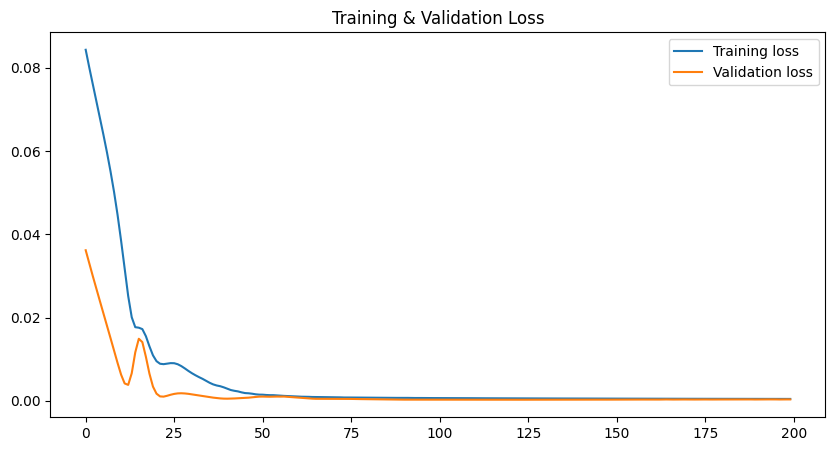

In [101]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_logger, label='Training loss')
plt.plot(val_loss_logger, label='Validation loss')
plt.title("Training & Validation Loss")
plt.legend()

# Save the figure as a PNG file
# plt.savefig("./Results/Loss.png")

plt.show()

### 4. Model prediction

#### 4.1 Predict previous dates for compariosn and visualization

In [94]:
df_X_ss = ss.transform(df.drop(columns=['PX_LAST']))
# df_X_ss = ss.transform(df.drop(columns=['PX_LAST', 'PX_HIGH', 'PX_LOW', 'PX_OPEN', 'PX_VOLUME'])) # old transformers
df_y_mm = mm.transform(df.PX_LAST.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 30, 10)
# convert to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshape the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 30, df_X_ss.shape[2]))

df_X_ss.shape

torch.Size([5359, 30, 48])

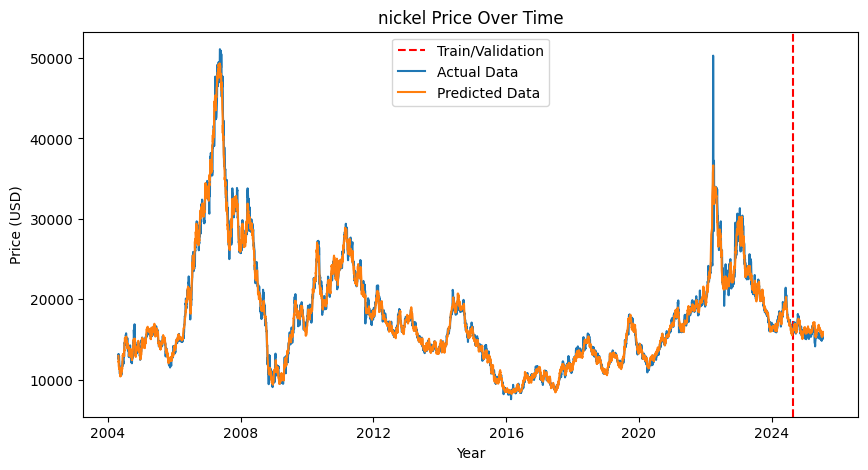

In [102]:
lstm.eval()

# Predict previous dates for compariosn and visualization
train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
plt.figure(figsize=(10,5))
plt.axvline(df.index[-len(y_test)], c='r', linestyle='--', label='Train/Validation')
plt.plot(df.index[-len(true):], true, label='Actual Data') # actual plot
plt.plot(df.index[-len(true):], preds, label='Predicted Data') # predicted plot
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.title("{} Price Over Time".format(datasets[dataset_idx]))
plt.legend()

# Save the figure as a PNG file
plt.savefig("./Results/Comparison.png")

plt.show()

In [74]:
# Save the model's state_dict
PATH = "./Model/LSTM_with_Indicators.pth"
torch.save(lstm.state_dict(), PATH)

#### 4.2 Predict prices of future 10 days

In [75]:
# Instantiate the model
lstm = LSTM(num_classes, 
            input_size, 
            hidden_size, 
            num_layers)

# Load the saved state_dict
PATH = "./Model/LSTM_with_Indicators.pth"
lstm.load_state_dict(torch.load(PATH))

# Set the model to evaluation mode (important for inference)
lstm.eval()

LSTM(
  (lstm1): LSTM(44, 64, num_layers=2, batch_first=True)
  (lstm2): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [104]:
# use last 30 days as input sequence
X_last = X[-30 : ]
X_last = ss.fit_transform(X_last)

# convert to pytorch tensors
X_last_tensors = torch.Tensor(X_last).unsqueeze(0)

# reshaping to rows, timestamps, features
X_last_tensors = torch.reshape(X_last_tensors, 
                               (X_last_tensors.shape[0], 30, 
                                X_last_tensors.shape[2]))

print("Testing Shape:", X_last_tensors.shape)

Testing Shape: torch.Size([1, 30, 48])


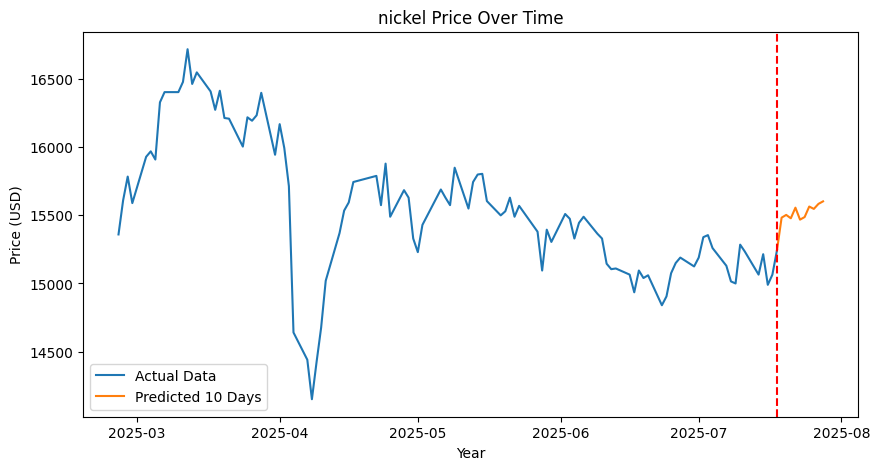

In [103]:
# predict prices of future 10 days
lstm.eval()

test_predict = lstm(X_last_tensors)
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

plt.figure(figsize=(10,5))
plt.plot(df.index[-100:], df.PX_LAST.iloc[-100:], label='Actual Data')
plt.plot([df.index[-1] + datetime.timedelta(days=i) for i in range(11)], [df.PX_LAST.iloc[-1]] + test_predict, label='Predicted 10 Days')
plt.axvline(x=df.index[-1], c='r', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.title("{} Price Over Time".format(datasets[dataset_idx]))
plt.legend()

# Save the figure as a PNG file
plt.savefig("./Results/Prediction.png")

plt.show()